# What is Foursquare opinion on splitting up Belgium?

## Capstone project for Coursera IBM Data science specialization
***

Introduction



Disclaimer (at least try)

In [1]:
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import requests

In [2]:
df_cities = pd.read_csv("datasets\worldcitiespop.csv",dtype = {"Country": "object",
                                                               "City": "object",
                                                               "AccentCity": "object",
                                                               "Region": "object",
                                                               "Population": "float64",
                                                               "Latitude": "float64",
                                                               "Longitude": "float64"})
df_cities.head()

,Country,City,AccentCity,Region,Population,Latitude,Longitude
0,ad,aixas,Aixàs,06,NaN,42.483333,1.466667
1,ad,aixirivali,Aixirivali,06,NaN,42.466667,1.500000
2,ad,aixirivall,Aixirivall,06,NaN,42.466667,1.500000
3,ad,aixirvall,Aixirvall,06,NaN,42.466667,1.500000
4,ad,aixovall,Aixovall,06,NaN,42.466667,1.483333


In [3]:
df_belg = df_cities[df_cities["Country"] == "be"]
print(df_belg.shape)
print(df_belg.dropna().shape)

(16218, 7)
(503, 7)


In [4]:
df_belg.dropna(inplace = True)

c:\users\adral\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
df_belg.drop(["AccentCity","Region"],axis=1,inplace = True)

c:\users\adral\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
df_countrycode = pd.read_csv("datasets\Countrycodes.csv")


In [17]:
dict_country2 = df_countrycode.set_index("alpha-2").to_dict()["name"]


In [18]:
df_cities["Country"] = df_cities["Country"].str.upper()
df_cities.head()

,Country,City,AccentCity,Region,Population,Latitude,Longitude
6,AD,andorra la vella,Andorra la Vella,07,20430.0,42.500000,1.516667
20,AD,canillo,Canillo,02,3292.0,42.566667,1.600000
32,AD,encamp,Encamp,03,11224.0,42.533333,1.583333
49,AD,la massana,La Massana,04,7211.0,42.550000,1.516667
53,AD,les escaldes,Les Escaldes,08,15854.0,42.500000,1.533333


In [19]:
df_cities.replace({"Country": dict_country2}, inplace=True)
df_cities.drop(["AccentCity","Region"],axis=1,inplace = True)


In [20]:
df_cities.reset_index(inplace = True, drop = True)
df_cities.head()

,Country,City,Population,Latitude,Longitude
0,Andorra,andorra la vella,20430.0,42.500000,1.516667
1,Andorra,canillo,3292.0,42.566667,1.600000
2,Andorra,encamp,11224.0,42.533333,1.583333
3,Andorra,la massana,7211.0,42.550000,1.516667
4,Andorra,les escaldes,15854.0,42.500000,1.533333


Creation of a function that retrieve the position of the 5 most populated cities of a country

In [8]:
import folium

In [9]:
#df_citiesSL = df_cities.sort_values(by="Population", ascending = False).head(500)

Worldmap= folium.Map(location=[40,40], zoom_start=1)

# add markers to map
for lat, lng, Country, City in zip(df_belg['Latitude'], df_belg['Longitude'], df_belg['Country'], df_belg['City']):
    label = '{}, {}'.format(Country, City)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Worldmap)  
    
Worldmap

In [10]:
#hopefully that is secure enough :)
with open ("foursquare_clientid.txt","r") as file1:
    CLIENT_ID = file1.read()
with open ("foursquare_secret.txt","r") as file2:
    CLIENT_SECRET = file2.read()
VERSION = '20180605'
LIMIT = 100
radius = 2000

In [11]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print('an issue with the city: ',name)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
world_venues =  getNearbyVenues(names=df_belg['City'],
                                   latitudes=df_belg['Latitude'],
                                   longitudes=df_belg['Longitude']
                                  )

aalst
aalter
aarschot
aartselaar
alken
alveringem
amay
amel
andenne
anderlues
anhee
ans
anthisnes
antoing
antwerp
anzegem
ardooie
arendonk
arlon
as
asse
assenede
assesse
ath
attert
aubange
aubel
avelgem
awans
aywaille
baarle-hertog
baelen
balen
bassenge
bastogne
beaumont
beauraing
beauvechain
beernem
beerse
beersel
begijnendijk
bekkevoort
beloeil
beringen
berlaar
berlare
berloz
bernissart
bertem
bertogne
bertrix
bever
beveren
beyne-heusay
bierbeek
bievre
bilzen
binche
blankenberge
blegny
bocholt
boechout
bonheiden
boom
boortmeerbeek
borgloon
bornem
borsbeek
bouillon
boussu
boutersem
braine-le-chateau
braine-le-comte
braives
brasschaat
brecht
bredene
bree
brugelette
brugge
brunehaut
brussels
buggenhout
bullingen
burdinne
butgenbach
celles
cerfontaine
chapelle-lez-herlaimont
charleroi
chastre
chatelet
chaudfontaine
chaumont-gistoux
chievres
chimay
chiny
ciney
clavier
colfontaine
comblain-au-pont
courcelles
court-saint-etienne
couvin
crisnee
dalhem
damme
daverdisse
deerlijk
de haan
deinze

In [13]:
world_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,aalst,50.933333,4.033333,Basic-Fit,50.934496,4.034168,Gym / Fitness Center
1,aalst,50.933333,4.033333,De Prins Drinkt Koffie,50.934941,4.038068,Coffee Shop
2,aalst,50.933333,4.033333,Tang's Palace,50.935172,4.038079,Chinese Restaurant
3,aalst,50.933333,4.033333,Healthfactor Gym,50.930120,4.035189,Gym / Fitness Center
4,aalst,50.933333,4.033333,Pizza Talia,50.932481,4.030968,Pizza Place


In [14]:
world_venues.shape

(6125, 7)

In [15]:
# one hot encoding
WV_onehot = pd.get_dummies(world_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
WV_onehot['Neighborhood'] = world_venues['Neighborhood'] 

# move neighborhood column to the first column
WV_onehot = WV_onehot.reindex(sorted(WV_onehot.columns), axis=1)
WV_onehot = WV_onehot.reindex(['Neighborhood'] + list([a for a in WV_onehot.columns if a != 'Neighborhood']), axis=1)

WV_onehot.head()

,Neighborhood,ATM,Accessories Store,Airport,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Waterfront,Weight Loss Center,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,aalst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,aalst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,aalst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,aalst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,aalst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
world_grouped = WV_onehot.groupby('Neighborhood').mean().reset_index()
world_grouped

,Neighborhood,ATM,Accessories Store,Airport,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Waterfront,Weight Loss Center,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,aalst,0.0,0.000000,0.0,0.00,0.000000,0.0,0.026316,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.026316,0.0,0.000000,0.0,0.000000,0.000000
1,aalter,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.02439,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,aarschot,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,aartselaar,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.034483,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,alken,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
5,alveringem,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
6,amay,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
7,andenne,0.0,0.000000,0.0,0.00,0.333333,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
8,anderlues,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
9,anhee,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [19]:
world_grouped.shape

(445, 369)

In [50]:
# set number of clusters
kclusters = 5

world_grouped_clustering = world_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(world_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 4, 0, 0, 0, 4, 4, 4, 4])

In [51]:
World_merged = df_belg
world_grouped_labels = world_grouped
world_grouped_labels["Cluster Labels"]= kmeans.labels_
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
World_merged = World_merged.join(world_grouped_labels.set_index('Neighborhood'), on='City')

World_merged.dropna(inplace = True)
World_merged["Cluster Labels"] = World_merged["Cluster Labels"].astype(int)
World_merged.head() # check the last columns!

,Country,City,Population,Latitude,Longitude,Cluster Labels,ATM,Accessories Store,Airport,Antique Shop,...,Waterfront,Weight Loss Center,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
216113,be,aalst,77534.0,50.933333,4.033333,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.026316,0.0,0.0,0.0,0.0,0.0
216117,be,aalter,18802.0,51.083333,3.450000,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02439,0.000000,0.0,0.0,0.0,0.0,0.0
216138,be,aarschot,27656.0,50.983333,4.833333,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
216144,be,aartselaar,14193.0,51.133333,4.383333,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
216263,be,alken,10933.0,50.866667,5.300000,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0


In [53]:
belgium_top = World_merged.sort_values("Population", ascending = False).head(50)
# create map
map_clusters = folium.Map(location=[40,40], zoom_start=1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(belgium_top['Latitude'], belgium_top['Longitude'], belgium_top['City'], belgium_top['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [25]:
world_grouped

,Cluster Labels,Neighborhood,ATM,Accessories Store,Airport,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Waterfront,Weight Loss Center,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,aalst,0.0,0.000000,0.0,0.00,0.000000,0.0,0.026316,0.000000,...,0.0,0.000000,0.0,0.00000,0.026316,0.0,0.000000,0.0,0.000000,0.000000
1,0,aalter,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.02439,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,0,aarschot,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,0,aartselaar,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0,alken,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
5,0,alveringem,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
6,0,amay,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
7,0,andenne,0.0,0.000000,0.0,0.00,0.333333,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
8,0,anderlues,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
9,0,anhee,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [ ]:
# test with Italy

ItalianCities = get_top5CitiesPos ("IT")
map_italy = folium.Map(location=ItalianCities[0], zoom_start=6)

# add markers to map
for lat, lng in ItalianCities:
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_italy)  
    
map_italy

In [ ]:
Roma_pos = ItalianCities[0]
print(Roma_pos[0], Roma_pos[1])
latmovement = 0.01
lngmovement = 0.01



Roma_pos_surr= [(Roma_pos[0]-latmovement,Roma_pos[1]-lngmovement),
                (Roma_pos[0]-latmovement,Roma_pos[1]),
                (Roma_pos[0]-latmovement,Roma_pos[1]+lngmovement),
                (Roma_pos[0],Roma_pos[1]-lngmovement),
                (Roma_pos[0],Roma_pos[1]),
                (Roma_pos[0],Roma_pos[1]+lngmovement),
                (Roma_pos[0]+latmovement,Roma_pos[1]-lngmovement),
                (Roma_pos[0]+latmovement,Roma_pos[1]),
                (Roma_pos[0]+latmovement,Roma_pos[1]+lngmovement)]

map_roma = folium.Map(location=Roma_pos, zoom_start=14)

# add markers to map
for lat, lng in Roma_pos_surr:
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_roma)  
    
map_roma



In [ ]:
BelgianCities = get_top5CitiesPos ("BE")

Roma_pos = BelgianCities[3]
print(Roma_pos[0], Roma_pos[1])
latmovement = 0.01
lngmovement = 0.01



Roma_pos_surr= [(Roma_pos[0]-latmovement,Roma_pos[1]-lngmovement),
                (Roma_pos[0]-latmovement,Roma_pos[1]),
                (Roma_pos[0]-latmovement,Roma_pos[1]+lngmovement),
                (Roma_pos[0],Roma_pos[1]-lngmovement),
                (Roma_pos[0],Roma_pos[1]),
                (Roma_pos[0],Roma_pos[1]+lngmovement),
                (Roma_pos[0]+latmovement,Roma_pos[1]-lngmovement),
                (Roma_pos[0]+latmovement,Roma_pos[1]),
                (Roma_pos[0]+latmovement,Roma_pos[1]+lngmovement)]

map_roma = folium.Map(location=Roma_pos, zoom_start=14)

# add markers to map
for lat, lng in Roma_pos_surr:
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_roma)  
    
map_roma


***
***
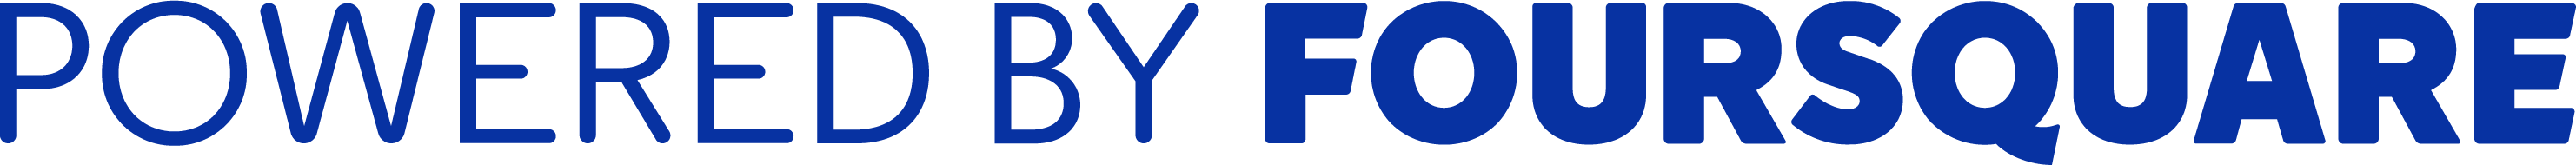
Venues data base on geoposition is from foursquare api (as required in the Capstone instruction):
> https://foursquare.com/
***
***


Dataset for list of cities with pop and lat lng downloaded from kaggle:
>https://www.kaggle.com/max-mind/world-cities-database/downloads/world-cities-database.zip/3

OPEN DATA LICENSE for MaxMind WorldCities and Postal Code Databases

Copyright (c) 2008 MaxMind Inc.  All Rights Reserved.

The database uses toponymic information, based on the Geographic Names Data Base, containing official standard names approved by
the United States
Board on Geographic Names and maintained by the National Geospatial-Intelligence Agency. More information is available at the Maps and
Geodata link at www.nga.mil. The National Geospatial-Intelligence Agency name, initials, and seal
are protected by 10 United States
Code Section 445.

It also uses free population data from Stefan Helders www.world-gazetteer.com.
Visit his website to download the free population data.  Our database
combines Stefan's population data with the list of all cities in the world.

All advertising materials and documentation mentioning features or use of
this database must display the following acknowledgment:
"This product includes data created by MaxMind, available from
http://www.maxmind.com/"

Redistribution and use with or without modification, are permitted provided
that the following conditions are met:
1. Redistributions must retain the above copyright notice, this list of
conditions and the following disclaimer in the documentation and/or other
materials provided with the distribution. 
2. All advertising materials and documentation mentioning features or use of
this database must display the following acknowledgement:
"This product includes data created by MaxMind, available from
http://www.maxmind.com/"
3. "MaxMind" may not be used to endorse or promote products derived from this
database without specific prior written permission.

THIS DATABASE IS PROVIDED BY MAXMIND.COM ``AS IS'' AND ANY 
EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED 
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE 
DISCLAIMED. IN NO EVENT SHALL MAXMIND.COM BE LIABLE FOR ANY 
DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES 
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; 
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT 
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS 
DATABASE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
***
***


Dataset for cities with region used for belgium city is from geonames. I downloaded it at:
>https://datahub.io/core/world-cities#readme

***
***

Data from mapping country code to country from wikipedia downloaded at:
> https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
***
***